Activate conda environment anopheles.yml

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import sys
import seaborn
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

import os, io, random
import string

### Import data

haplotypes have already been filtered to only contain mosquito targets and only samples with at least 10 amplicons.
td is ordered by phylogeny based on the tree displayed in manuscript.

In [4]:
#import files
refbase = pd.read_csv("../../data/haplotypes-NNv1.csv")
td = pd.read_csv("sample_info.csv", index_col=0)
samples = td.index.values

### Functions

In [3]:
def samp_samp_amp_dist(samp1, samp2, amp, a, ref8mers):
    s1 = amp.loc[amp.s_Sample == samp1, 'combUID'].unique()
    s2 = amp.loc[amp.s_Sample == samp2, 'combUID'].unique()
    dist = 0
    for sq1 in s1:
        for sq2 in s2:
            c1 = int(sq1.split('-')[1])
            c2 = int(sq2.split('-')[1])
            d= np.sum(np.abs(ref8mers[a,c1,:] - ref8mers[a,c2,:]))/np.sum(ref8mers[a,c1,:] + ref8mers[a,c2,:])
            dist += d
            #print("sample 1 ", sq1, ", sample 2 ", sq2, ": distance ", d)
    dist = dist/(len(s1)*len(s2))
    #print("final distance: ", dist)
    return(dist)

In [13]:
def construct_distance_array(refbase, ref8mers, samples):
    
    #initialise distance array
    distances = np.empty((62, len(samples), len(samples)))
    distances[:] = np.nan
    
    #restrict to per amplicon
    for a in np.arange(62):
        amp = refbase.loc[refbase.target == a]
        samp = samples[np.isin(samples, amp.s_Sample)]
        
        #iterate through sample pairs
        for e, samp1 in enumerate(samples[:-1]):
            #check that sample has amplified at this target
            if np.isin(samp1, samp):
                for ee, samp2 in enumerate(samples[e+1:]):
                    if np.isin(samp2, samp):
                        distances[a,e,e+1+ee] = samp_samp_amp_dist(samp1, samp2, amp, a, ref8mers)
                        distances[a,e+1+ee,e] = distances[a,e,e+1+ee]

        if np.isin(samples[-1], samp):
            dists = distances[a,-1,:]
        print("amplicon ", a, " done")
    return(distances)
            
    

In [5]:
def construct_kmer_dict(k):
    labels = []
    for i in itertools.product('ACGT', repeat=k):
        labels.append(''.join(i))
    kmerdict = dict(zip(labels, np.arange(4**k)))
    return(kmerdict)

In [6]:
def sample_kmer_table(k, seq, no_amp, x):
    kmerdict = construct_kmer_dict(k)
    table = np.zeros((no_amp, x, 4**k), dtype='int')
    for r in seq.index:
        combid = str.split(seq.loc[r,'combUID'], '-')
        t, u = int(combid[0]), int(combid[1])
        sq = seq.loc[r,'consensus']
        for i in np.arange(len(sq)-(k-1)):
            table[t,u,kmerdict[sq[i:i+k]]] += 1
    return(table)

In [7]:
def assign_combUID(haplotypes): 
    # assign IDs to unique sequences
    combuids = dict()
    for tgt, group in haplotypes.groupby(['target']):
        for (i, cons) in enumerate(group['consensus'].unique()):
            combuids[str(tgt)+cons] = '{}-{}'.format(tgt, i)
    haplotypes['combUID'] = (haplotypes.target.astype('str') + haplotypes.consensus).replace(combuids)
    return(haplotypes)

### Process data

In [36]:
refbase = assign_combUID(refbase)

In [37]:
#Make array unique 8mers
maxallele = refbase.groupby('target')['combUID'].nunique().max()
combUIDunique = refbase[['combUID', 'consensus']].drop_duplicates()
ref8mers = sample_kmer_table(8, combUIDunique, 62, maxallele)

In [2]:
#compute pairwise distances betweens samples
distances8 = construct_distance_array(refbase, ref8mers, samples)

In [39]:
np.save("results/0_sample_distances.npy", distances8)

In [2]:
distances8 = np.load("results/0_sample_distances.npy")

In [3]:
#size of squares (from taxonomy file in 1_compute_distances_refbase)
numfine = np.array([ 9,  1,  4,  5,  2,  1,  1,  4,  3,  3,  1,  2,  4,  2,  1,  4,  4,
        3,  2, 17,  6,  1, 11,  4, 11,  1,  5,  4,  5,  1,  1,  1,  1,  1,
        2,  1, 10,  6,  2,  2,  2,  5,  1,  3,  3,  2,  1,  5,  5,  4,  1,
        1,  1,  1,  1,  1])
numint = np.array([14,  7,  1,  1,  4,  3,  3,  1,  2,  7,  4,  4,  3,  2, 50,  1,  5,
        4,  7,  3,  2, 17,  2,  4,  5,  1,  3, 11,  5,  4,  1,  1,  1,  1,
        2])
numcoarse = np.array([56, 60, 12, 29,  3, 11,  9,  4,  2])

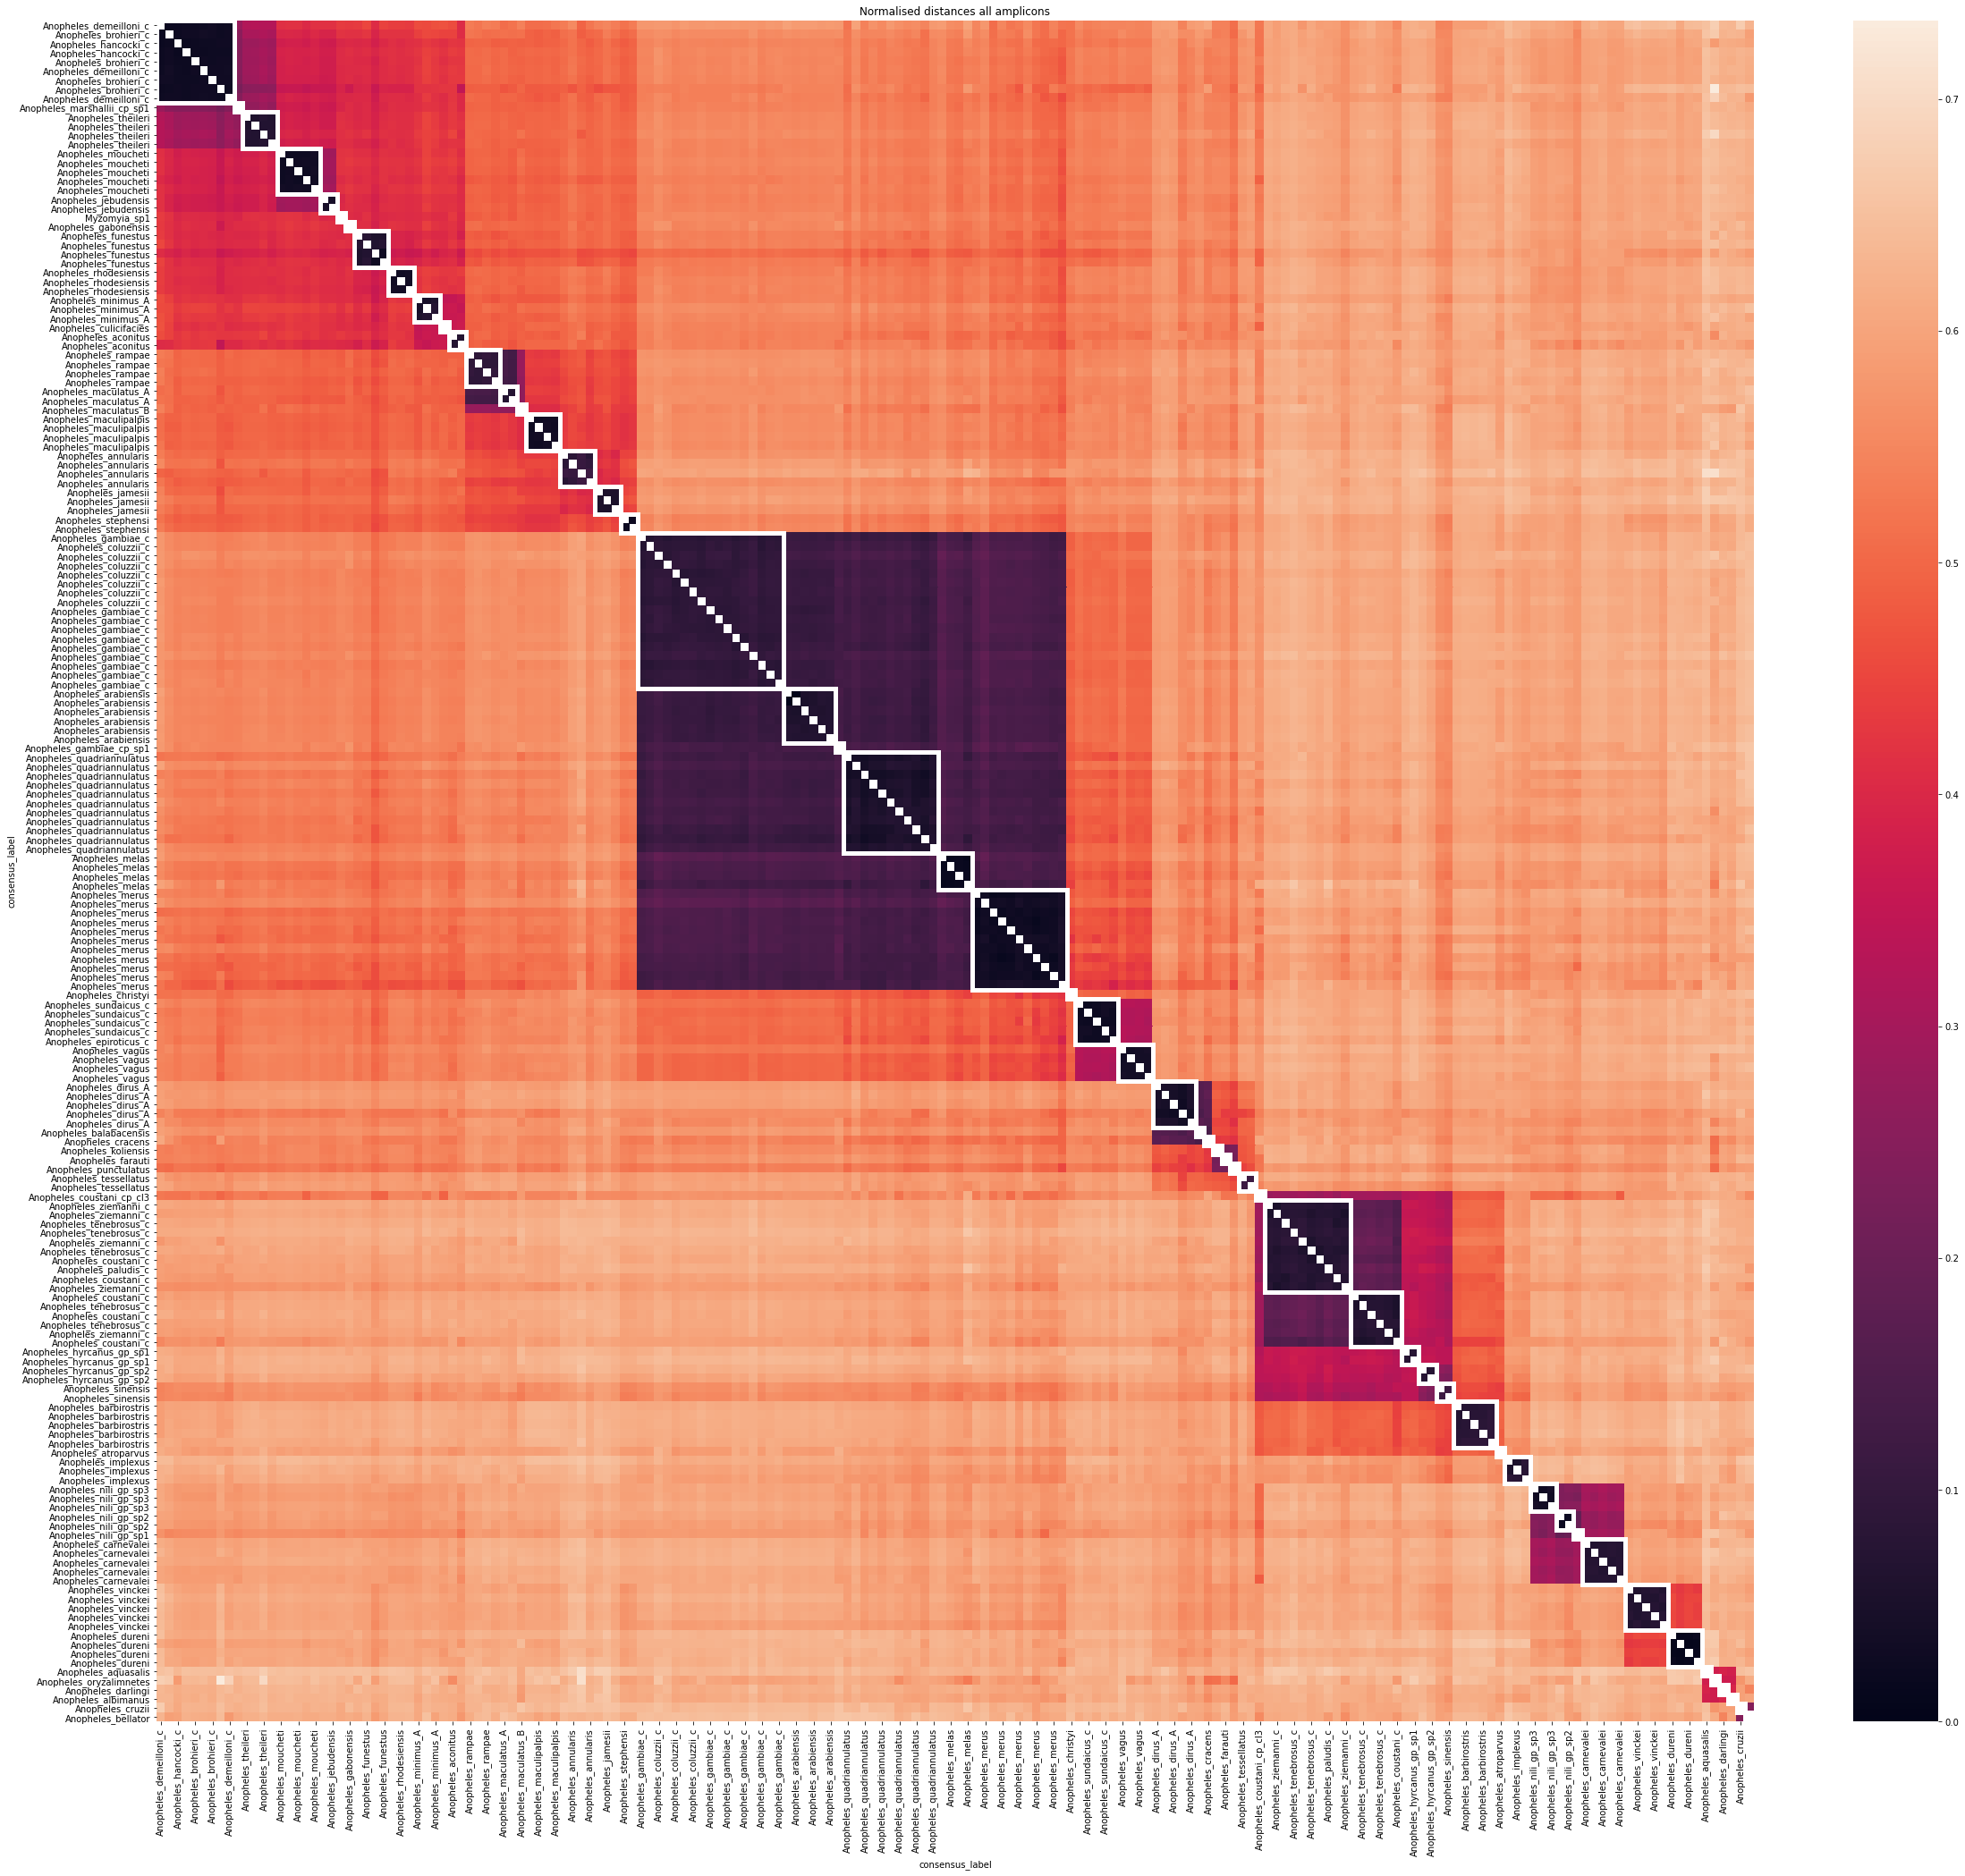

In [41]:
#show pairwise distances with fine-level species groups indicated
fig, ax = plt.subplots(figsize=(40,35))
norm = np.where((62-np.sum(np.isnan(distances8), axis=0))==0, -1, 62-np.sum(np.isnan(distances8), axis=0))
df = pd.DataFrame(np.nansum(distances8, axis=0)/norm, index=td.loc[samples, 'consensus_label'], columns=td.loc[samples, 'consensus_label'])
mask = np.all(np.isnan(distances8), axis=0)
snsplot = seaborn.heatmap(df, ax=ax, mask=mask).set_title('Normalised distances all amplicons')
x,y=0,0
for n in numfine:
    ax.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ='white',
                        linewidth = 5) )
    x+=n
    y+=n
plt.savefig("results/0_pairwise_distances.png")

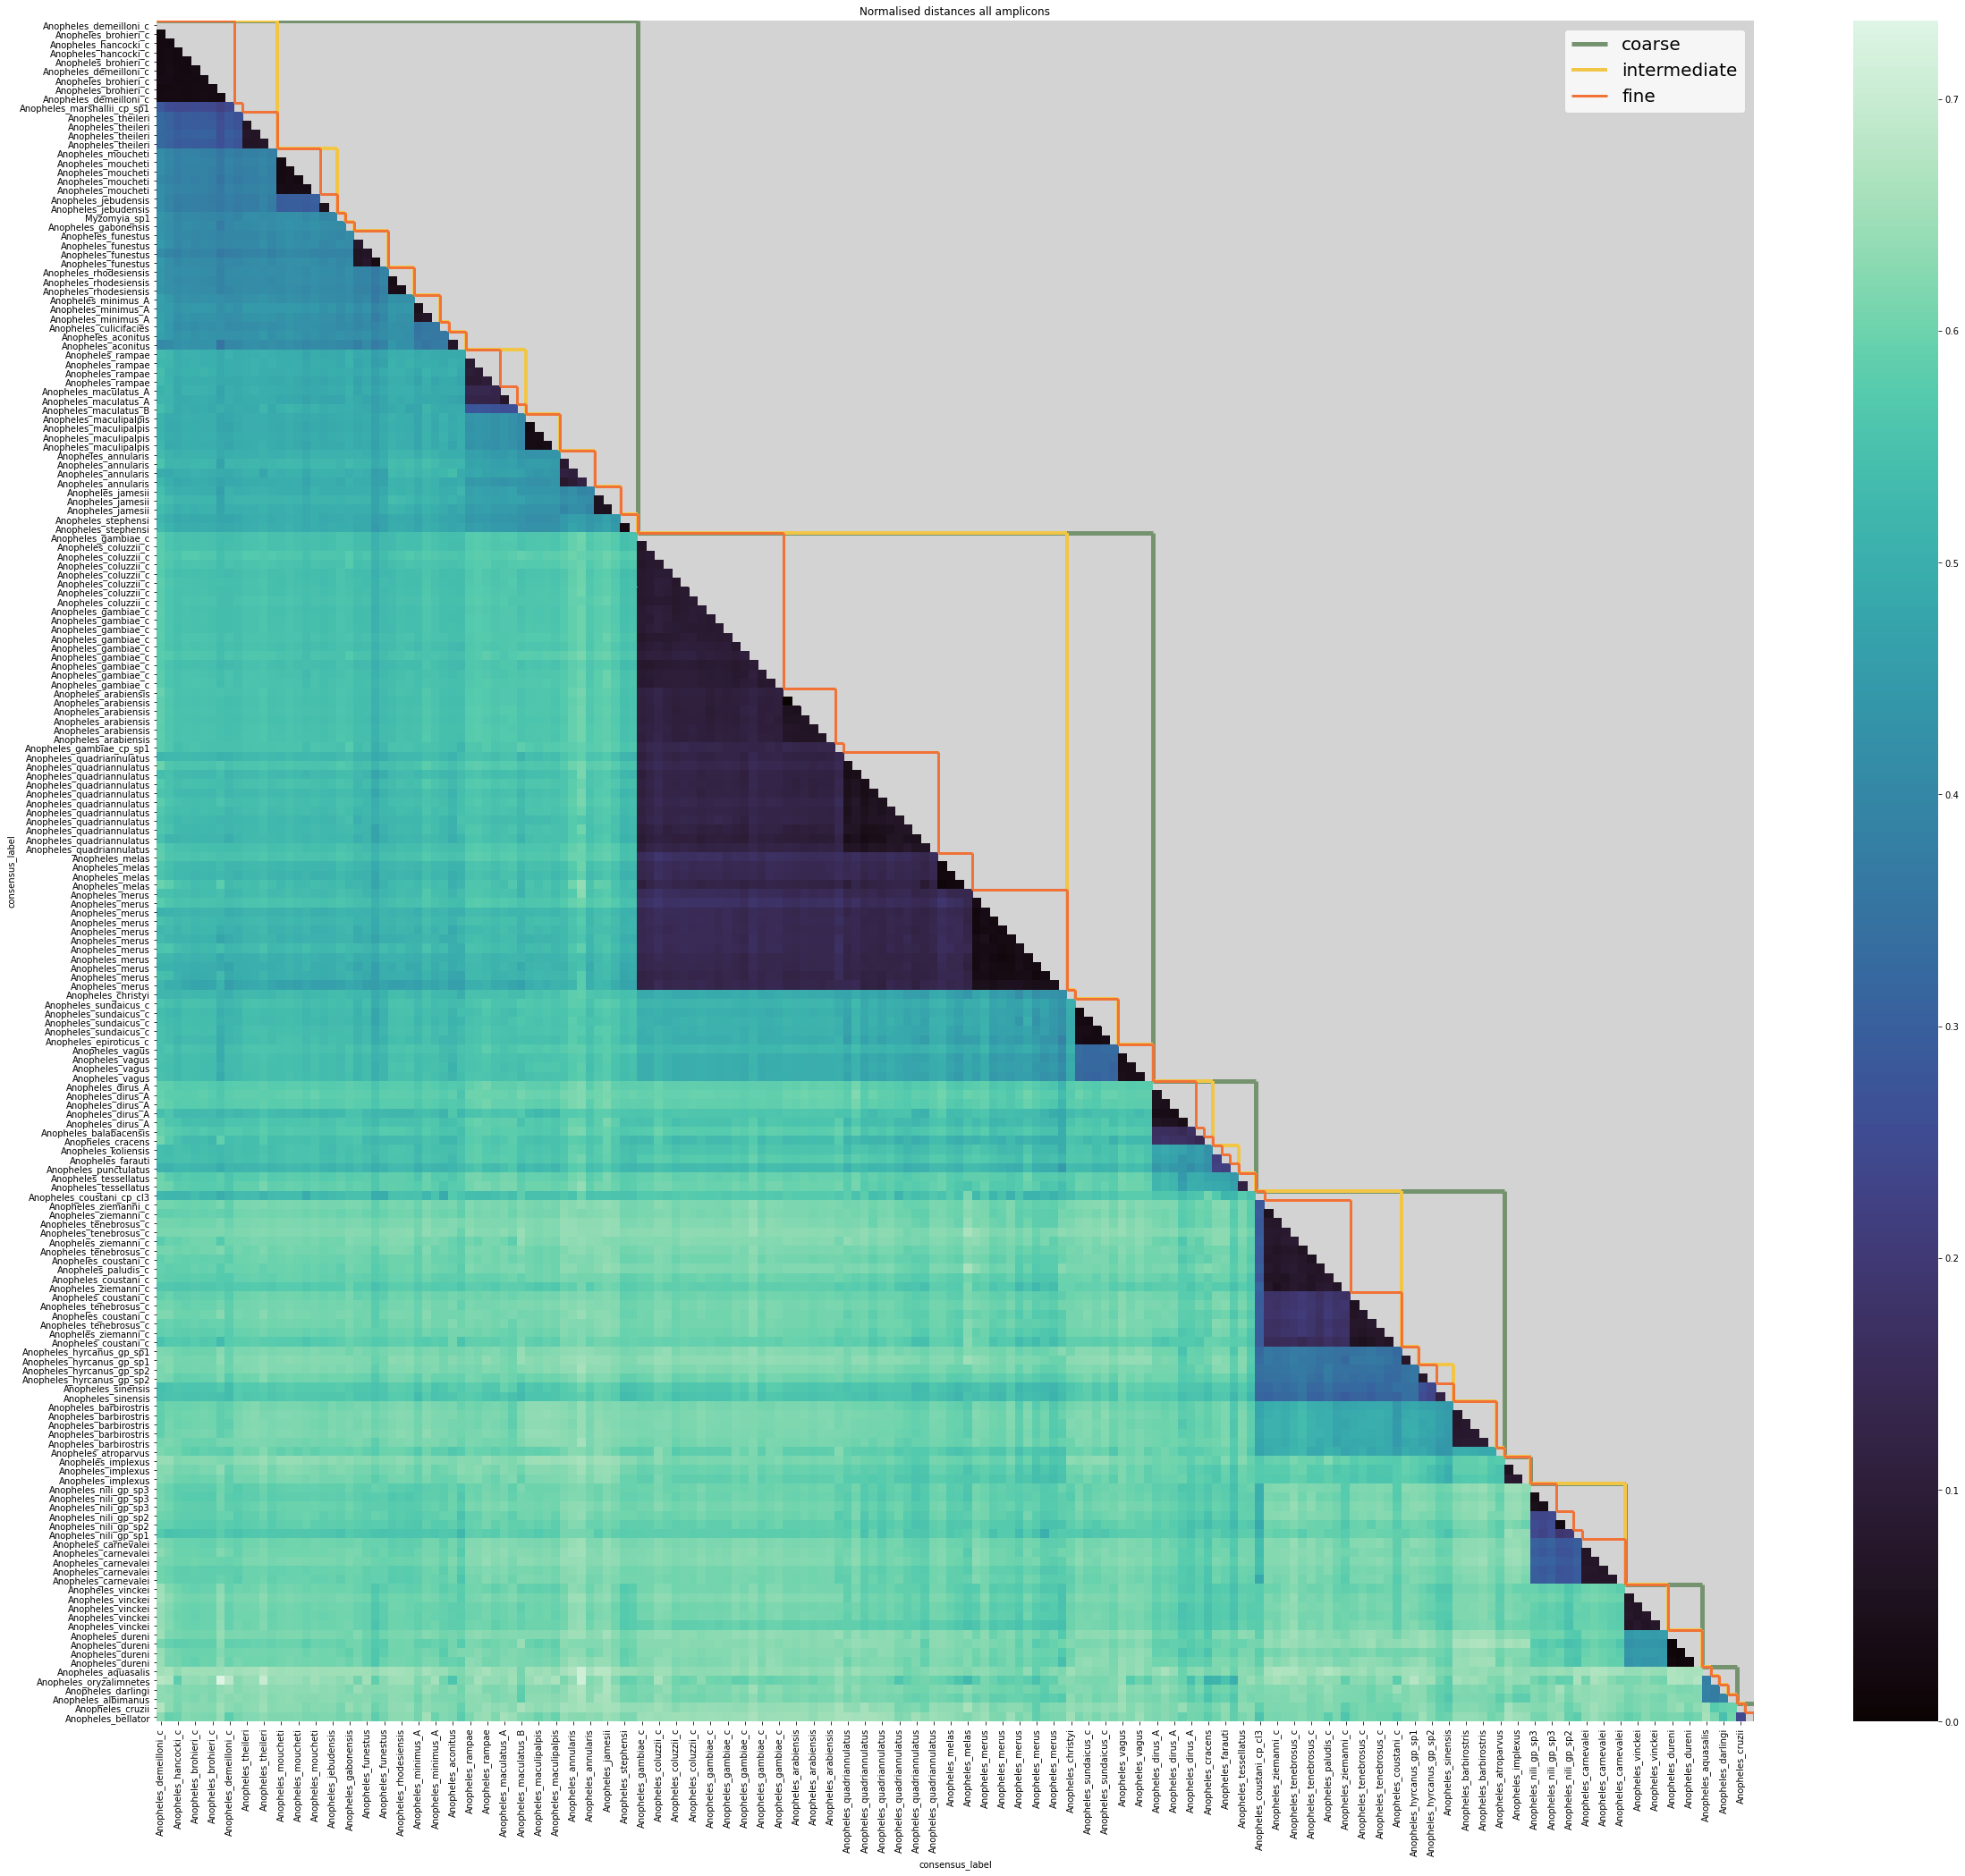

In [98]:
#show pairwise distances with fine, intermediate and coarse level species groups indicated
fig, ax = plt.subplots(figsize=(40,35))
norm = np.where((62-np.sum(np.isnan(distances8), axis=0))==0, -1, 62-np.sum(np.isnan(distances8), axis=0))
df = pd.DataFrame(np.nansum(distances8, axis=0)/norm, index=td.loc[samples, 'consensus_label'], columns=td.loc[samples, 'consensus_label'])
#mask = np.all(np.isnan(distances8), axis=0)
mask=np.triu(np.ones_like(df, dtype=bool))
snsplot = seaborn.heatmap(df, ax=ax, mask=mask, cmap='mako').set_title('Normalised distances all amplicons')

x,y=0,0
for n in numcoarse[:-1]:
    ax.vlines(x+n,y,y+n,color ="#769370", linewidth=5)
    ax.hlines(y,x,x+n,color ="#769370", linewidth=5)
    x+=n
    y+=n
ax.vlines(x+n,y,y+n,color ="#769370", linewidth=5)
ax.hlines(y,x,x+n,color ="#769370", linewidth=5, label='coarse')

x,y=0,0
for n in numint[:-1]:
    ax.vlines(x+n,y,y+n,color ="#F1C646", linewidth=4)
    ax.hlines(y,x,x+n,color ="#F1C646", linewidth=4)
    x+=n
    y+=n
ax.vlines(x+n,y,y+n,color ="#F1C646", linewidth=4)
ax.hlines(y,x,x+n,color ="#F1C646", linewidth=4, label='intermediate')

x,y=0,0
for n in numfine[:-1]:
    ax.vlines(x+n,y,y+n,color ="#F17236", linewidth=3)
    ax.hlines(y,x,x+n,color ="#F17236", linewidth=3)
    x+=n
    y+=n
ax.vlines(x+n,y,y+n,color ="#F17236", linewidth=3)
ax.hlines(y,x,x+n,color ="#F17236", linewidth=3, label='fine')
ax.legend(fontsize=20)
ax.patch.set_facecolor('lightgrey')
plt.savefig("results/0_distance_figure.png")

### Investigate distances

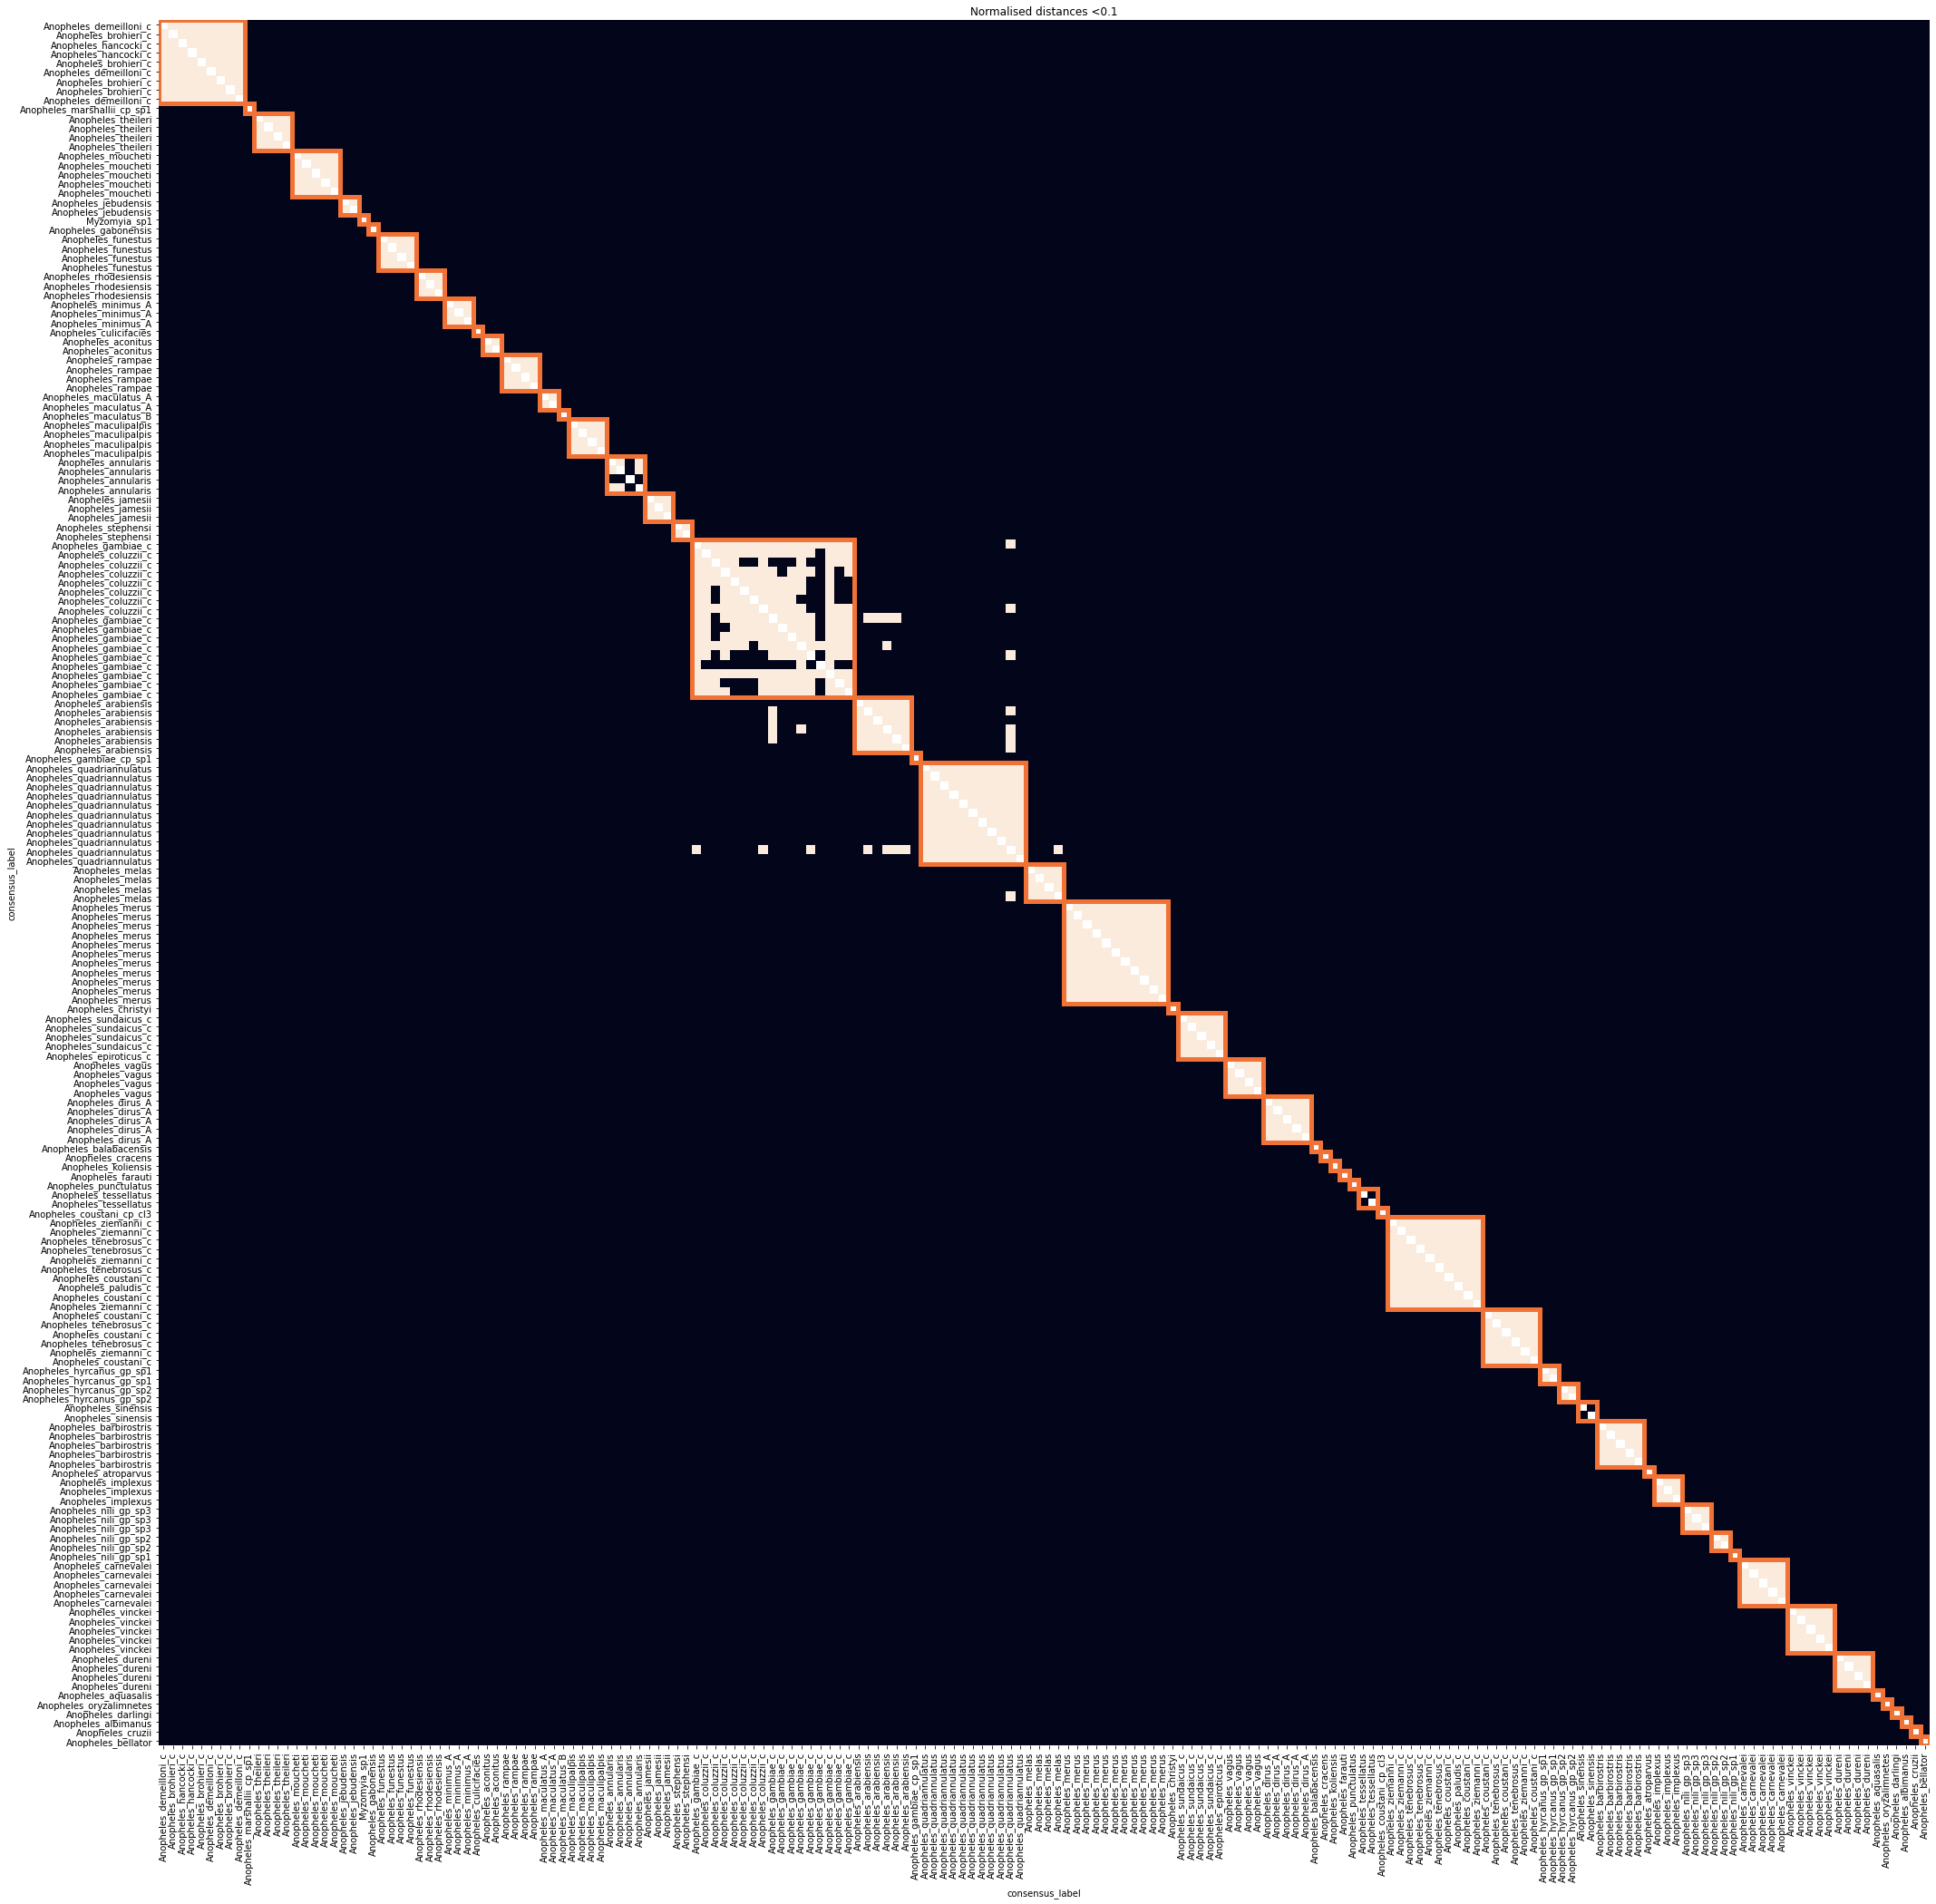

In [46]:
#for distance threshold 0.1, indicate which pairs have a distance smaller than the thresholds from each other
#good correspondance with species labels, except in some complexes (demeilloni, brohieri, hancocki; gambiae, coluzzii; sundaicus, epiroticus; coustani, tenebrosus, ziemanni, paludis)
th=0.1
fig, ax = plt.subplots(figsize=(35,35))
snsplot = seaborn.heatmap((df<th), ax=ax, mask=mask, cbar=False).set_title('Normalised distances <{}'.format(th))
x,y=0,0
for n in numfine:
    ax.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ="#F17236",
                        linewidth = 5) )
    x+=n
    y+=n
plt.savefig("results/0_distance_threshold_{}.png".format(th))

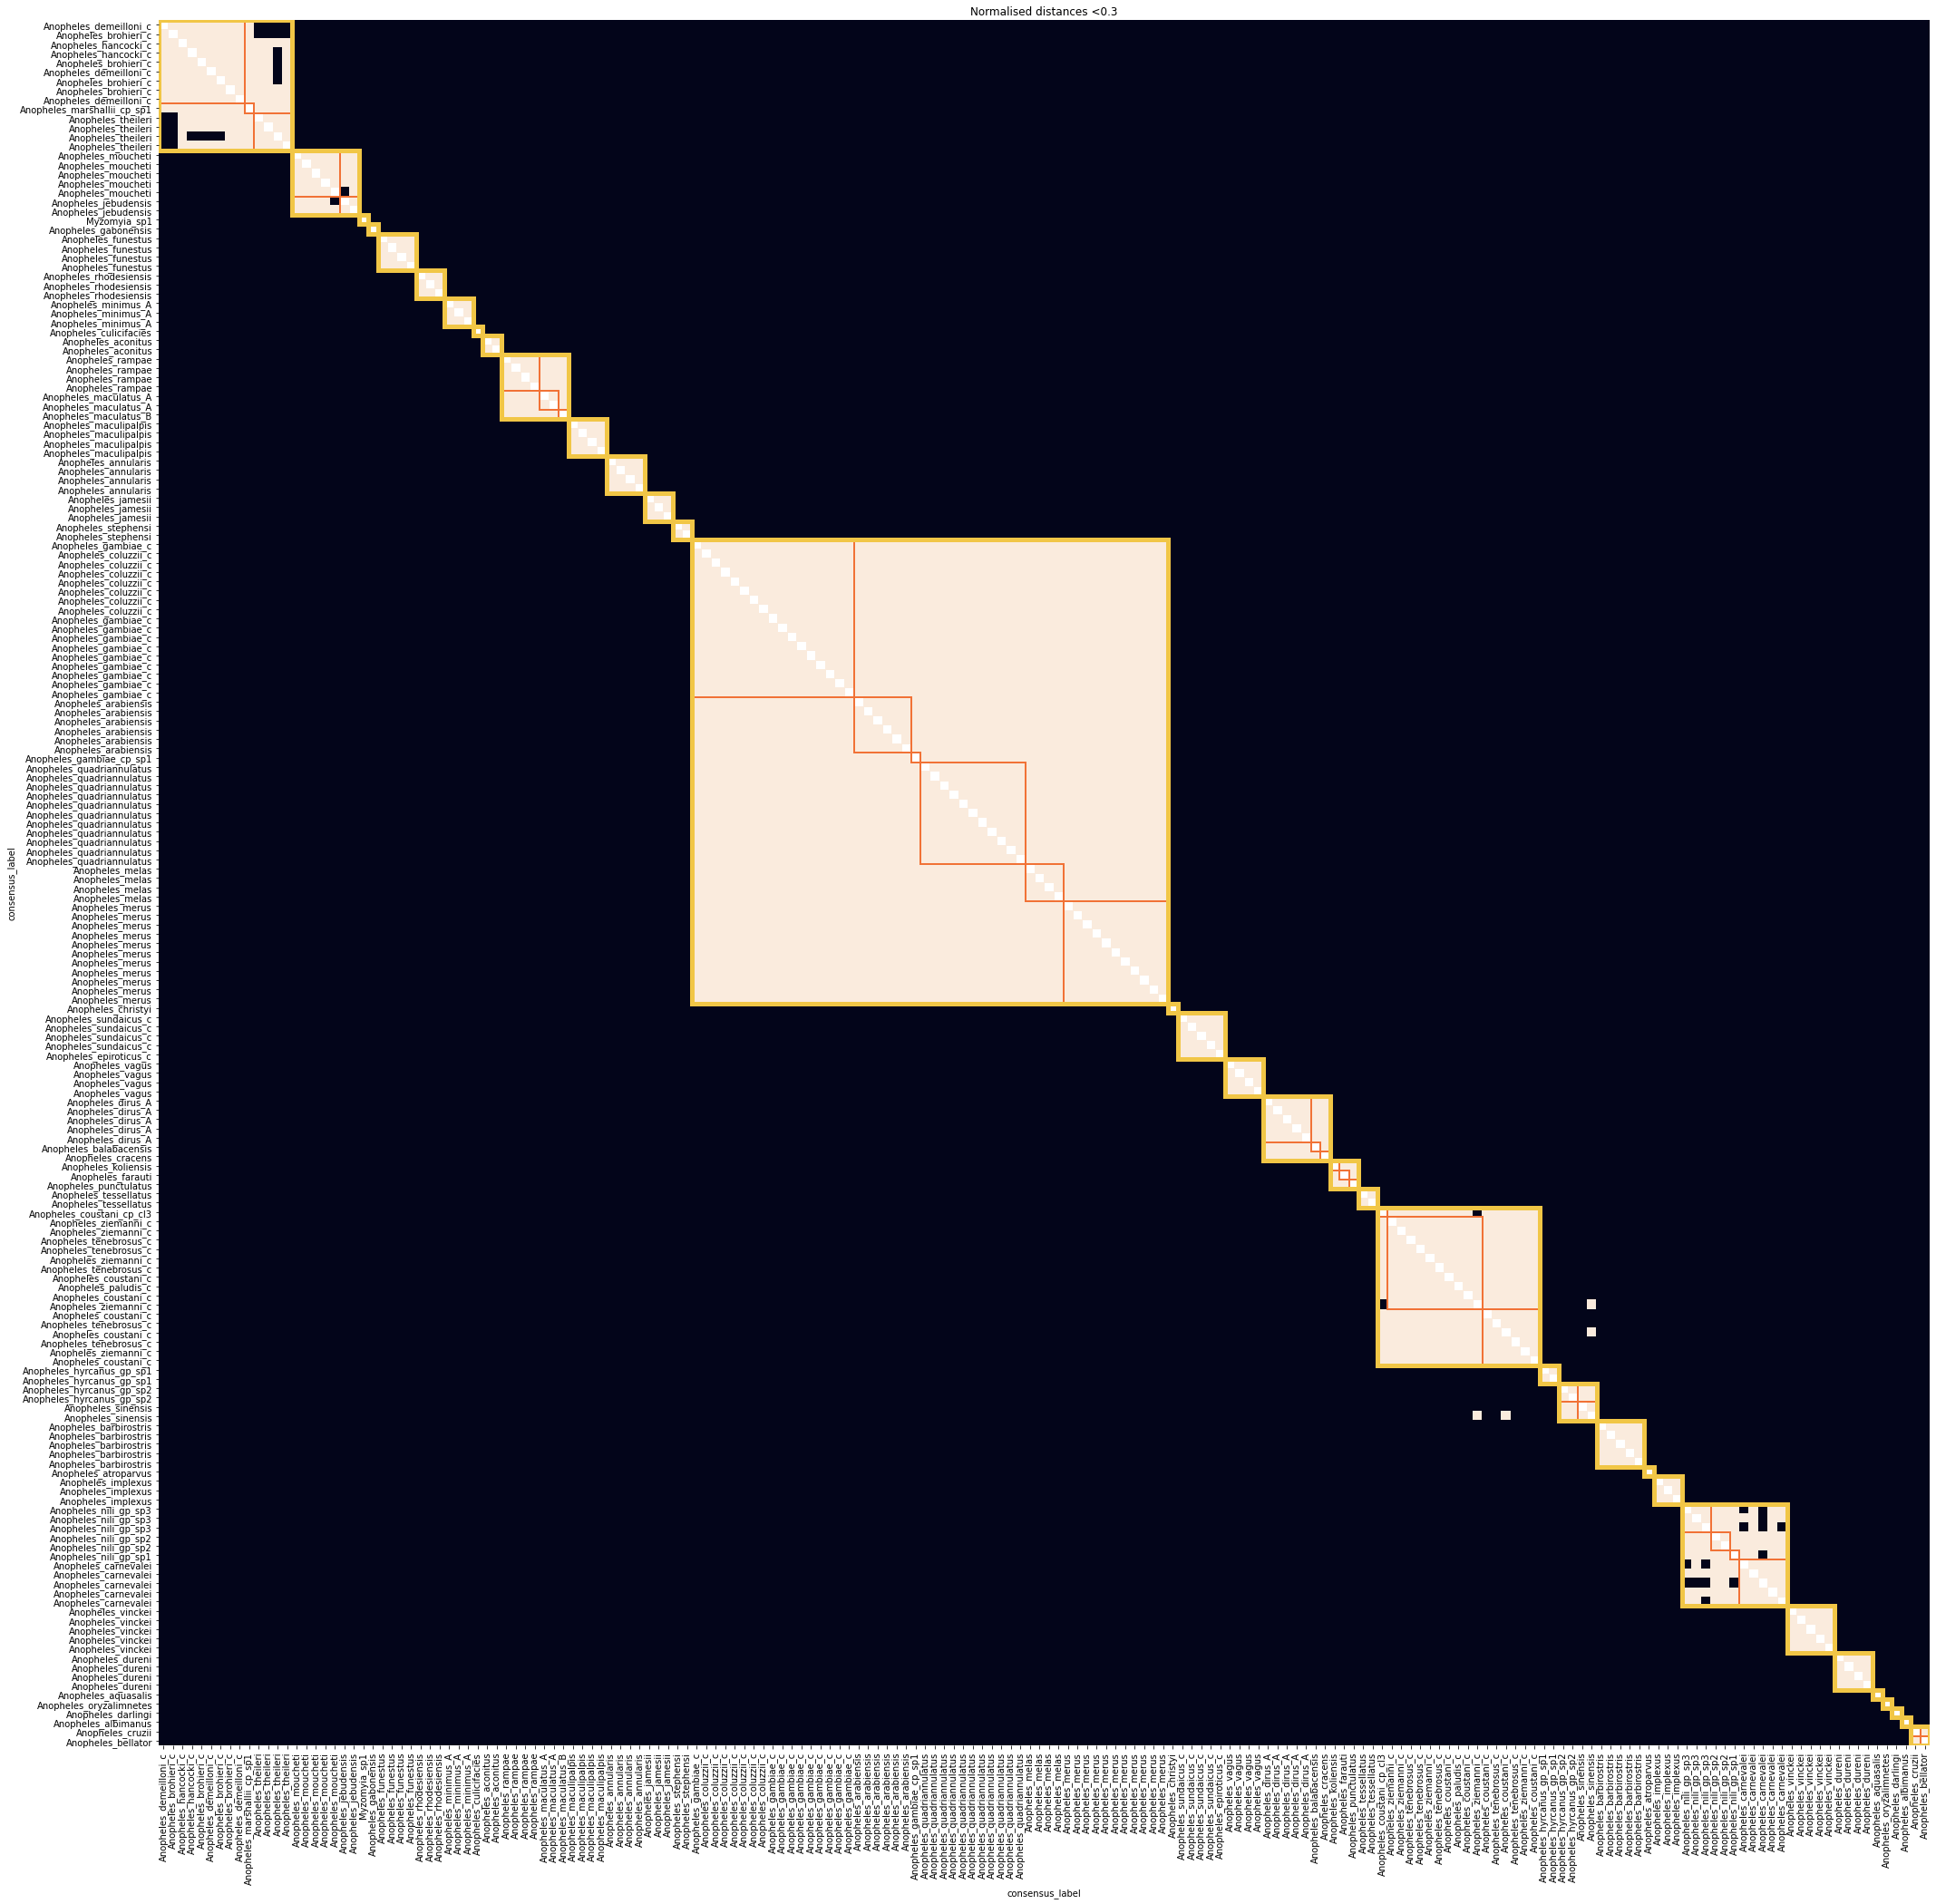

In [50]:
#for distance threshold 0.3, indicate which pairs have a distance smaller than the thresholds from each other
#the partitioning condition is very nearly satisfied and most single-sample-groups from fine level are now merged
th=0.3
fig, ax = plt.subplots(figsize=(35,35))
snsplot = seaborn.heatmap((df<th), ax=ax, mask=mask, cbar=False).set_title('Normalised distances <{}'.format(th))
x,y=0,0
for n in numfine:
    ax.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ="#F17236",
                        linewidth = 2) )
    x+=n
    y+=n
x,y=0,0
for n in numint:
    ax.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ="#F1C646",
                        linewidth = 5) )
    x+=n
    y+=n
plt.savefig("results/0_distance_threshold_{}.png".format(th))

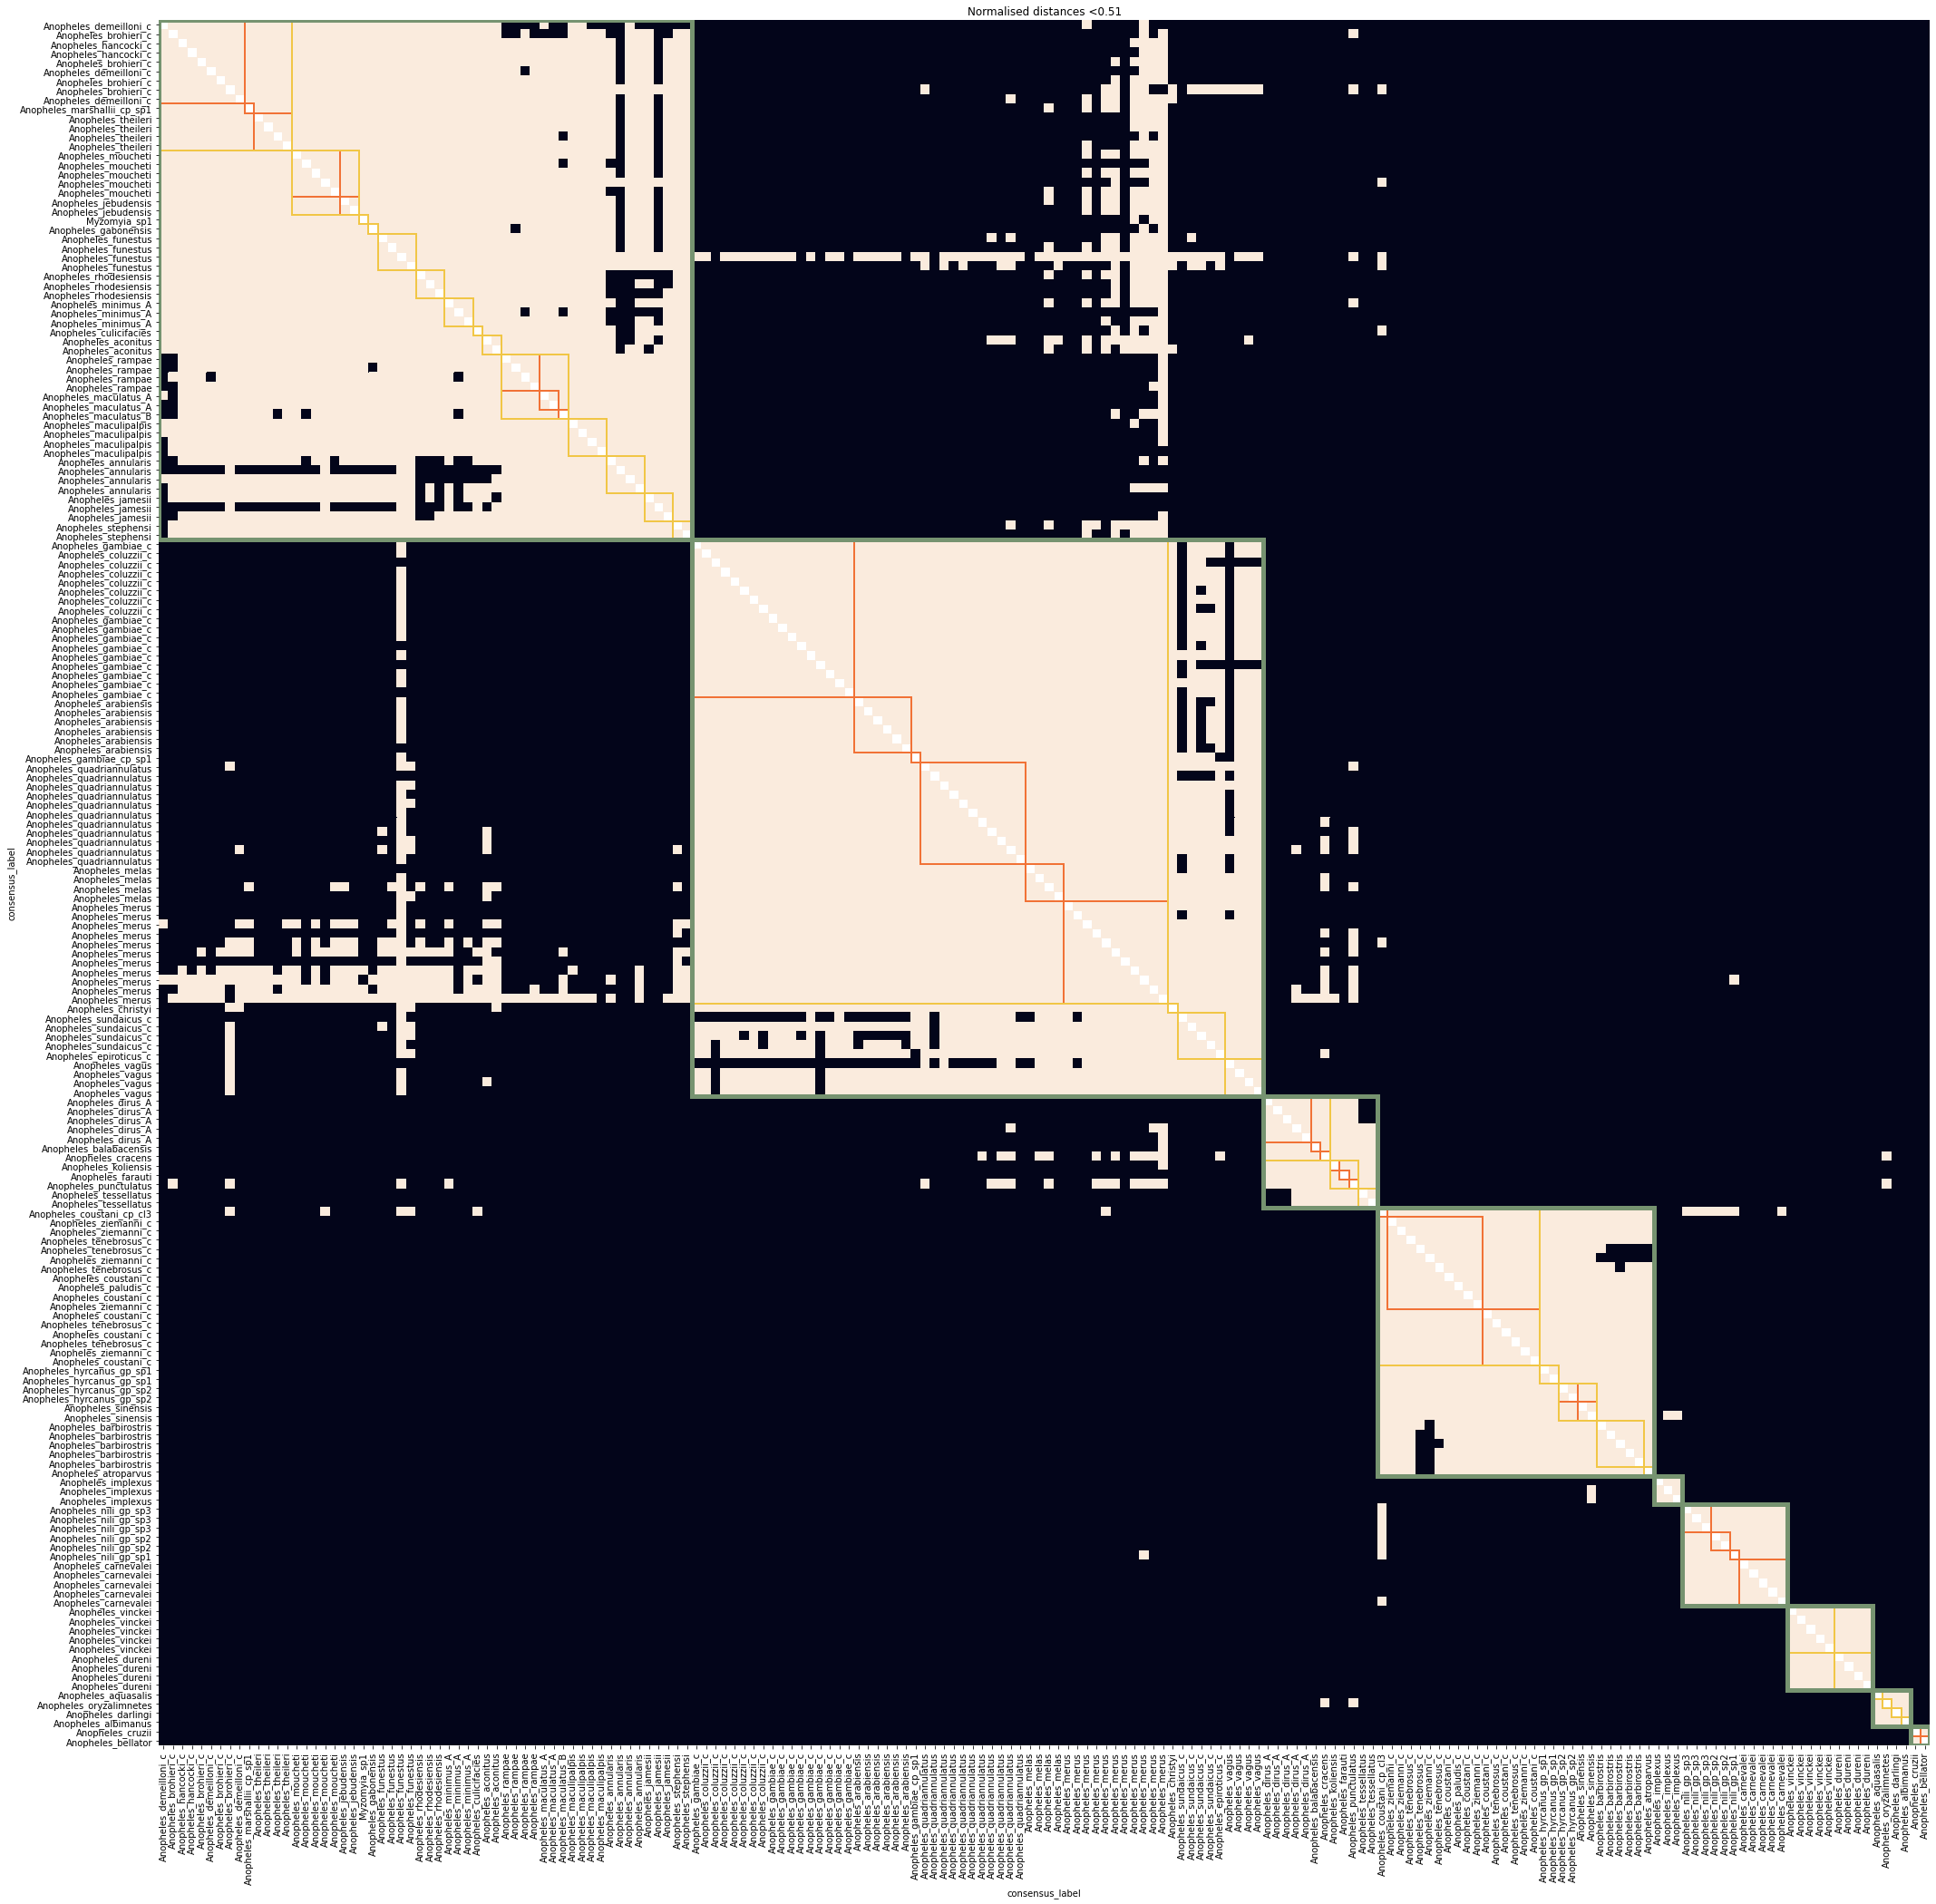

In [81]:
#for distance threshold 0.51, indicate which pairs have a distance smaller than the thresholds from each other
#paritioning condition more violated than before, but reasonably good correspondence to series level taxonomy
th=0.51
fig, ax = plt.subplots(figsize=(35,35))
snsplot = seaborn.heatmap((df<th), ax=ax, mask=mask, cbar=False).set_title('Normalised distances <{}'.format(th))
x,y=0,0
for n in numfine:
    ax.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ="#F17236",
                        linewidth = 2) )
    x+=n
    y+=n
x,y=0,0
for n in numint:
    ax.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ="#F1C646",
                        linewidth = 2) )
    x+=n
    y+=n
x,y=0,0
for n in numcoarse:
    ax.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ="#769370",
                        linewidth = 5) )
    x+=n
    y+=n
plt.savefig("results/0_distance_threshold_{}.png".format(th))

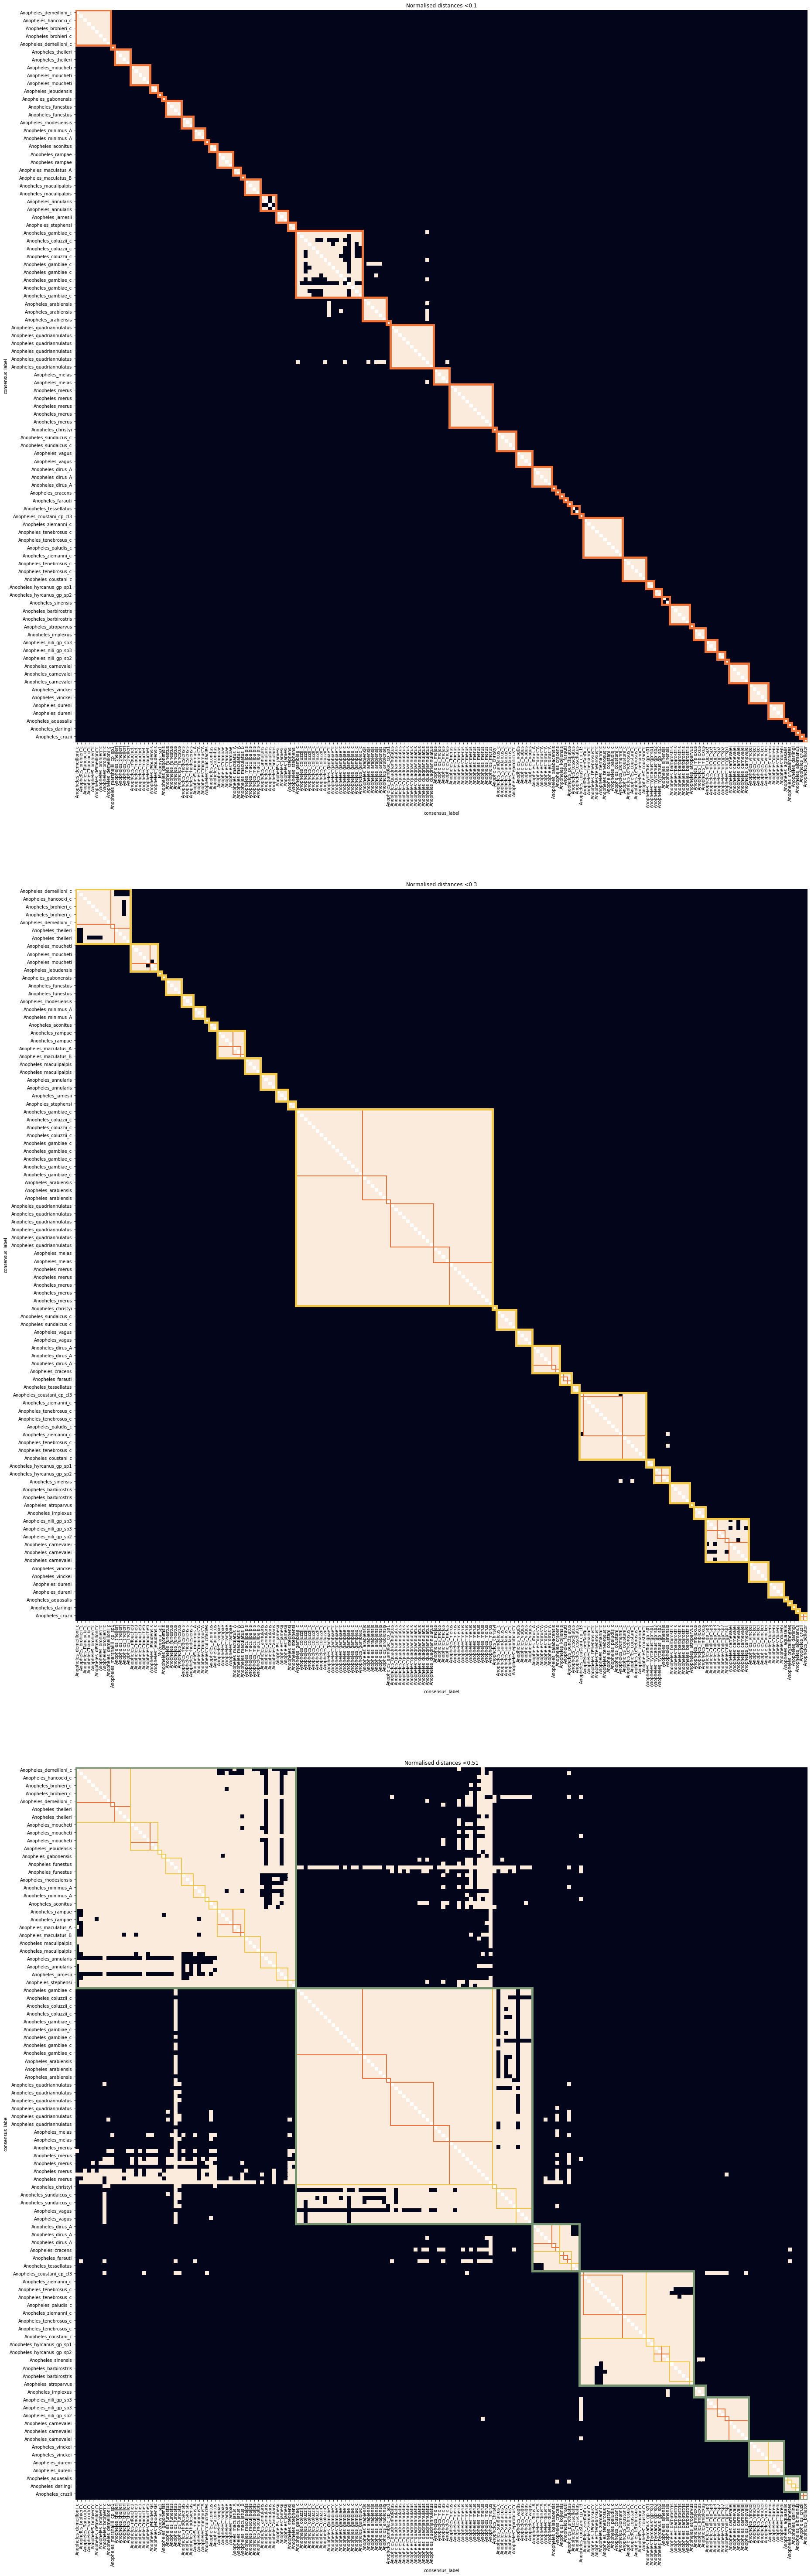

In [101]:
fig, ax = plt.subplots(3, 1, figsize=(35,105))
mask = np.all(np.isnan(distances8), axis=0)
for th, a in zip([0.1,0.3,0.51], [ax[0], ax[1], ax[2]]):
    snsplot = seaborn.heatmap((df<th), ax=a, mask=mask, cbar=False, square=True).set_title('Normalised distances <{}'.format(th))
for a, w in zip([ax[0], ax[1], ax[2]], [5,2,2]):
    x,y=0,0
    for n in numfine:
        a.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ="#F17236",
                        linewidth = w) )
        x+=n
        y+=n
for a, w in zip([ax[1], ax[2]], [5,2]):
    x,y=0,0
    for n in numint:
        a.add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ="#F1C646",
                        linewidth = w) )
        x+=n
        y+=n

x,y=0,0
for n in numcoarse:
    ax[2].add_patch( Rectangle((x,y),
                        n, n,
                        fc='none',
                        color ="#769370",
                        linewidth = 5) )
    x+=n
    y+=n
plt.savefig("results/0_distance_thresholds_combined.png".format(th))